In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os, sys
from interface import MaskRCNN
from cv2 import imread, imwrite
import numpy as np
import cv2
import time
from scipy.io import loadmat


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
datapath = '/beegfs/ua349/lstm/Penn_Action'

fpath = datapath + '/frames'
lpath = datapath + '/labels'

vidfolders = os.listdir(fpath)
vidfolders = sorted(vidfolders, key=lambda val: int(val))

center_frames = []

for folder in vidfolders:
    imgs = os.listdir('%s/%s' % (fpath, folder))
    imgs = sorted(imgs, key=lambda path: int(path.split('.')[0]))
    midind = int(len(imgs)/2)
    midfile = '%s/%s/%s' % (fpath, folder, imgs[midind])
    
    mat = loadmat('%s/%s.mat' % (lpath, folder))
    midbox = mat['bbox'][midind]

    img = cv2.cvtColor(imread(midfile), cv2.COLOR_BGR2RGB)
    center_frames.append([img, midbox, midfile])
    
assert len(center_frames) > 0

In [5]:
model = MaskRCNN()

In [6]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [11]:
def remask(img, proposed, visualize=False):
    results = [res for res in model.predict(img) if res.name is 'person']
    npeople = len(results)

    bestscore = 0
    bestind = 0
    if npeople > 0:

        for ind, res in enumerate(results):
            score = iou(proposed, [res.roi[1], res.roi[0], res.roi[3], res.roi[2]])
            if score > bestscore:
                bestscore = score
                bestind = ind
        bestobj = results[bestind]

    canvas = np.zeros(img.shape[:2], dtype=np.uint8)

    canvas[:, :] = 1
    if npeople > 0 and bestscore > 0.1:
        for res in results:
            if bestobj != res:
                # mask out anyone other than the matched person
                canvas[res.mask == 1] = 0
    elif bestscore == 0:
        # did not detect the main person - that's ok, just mask out anyone else dtected
        for res in results:
            canvas[res.mask == 1] = 0

    if npeople > 1 and visualize:
        plt.figure(figsize=(14, 10))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.gca().set_title(npeople)
        plt.imshow(img)

        plt.subplot(1, 3, 2)
        mask = np.zeros(img.shape[:2])
        box = [int(val) for val in proposed]
        mask[box[1]:box[3], box[0]:box[2]] = 1
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.subplot(1, 3, 3)
        ax = plt.gca()

        plt.imshow(img)
        plt.imshow(canvas, alpha=0.5, vmin=0, vmax=1)

        plt.show()
        plt.close()

    return canvas

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


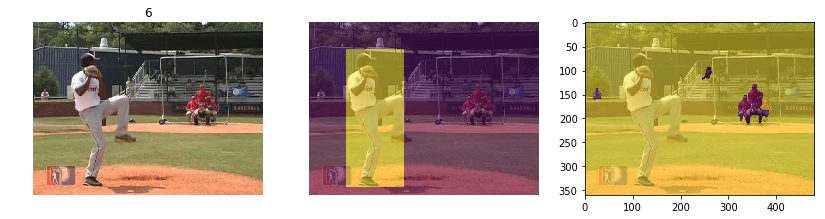

In [12]:
for ii, (img, box, impath) in enumerate(center_frames):
    t0 = time.time()
    
    mask = remask(img, box, visualize=True)
    break

In [ ]:
datapath = '/beegfs/ua349/lstm/Penn_Action'

fpath = datapath + '/frames'
lpath = datapath + '/labels'
maskpath = datapath + '/masks'

vidfolders = os.listdir(fpath)
vidfolders = sorted(vidfolders, key=lambda val: int(val))

center_frames = []

SKIP = 1150
for fii, folder in enumerate(vidfolders[SKIP:]):
    imgs = os.listdir('%s/%s' % (fpath, folder))
    imgs = sorted(imgs, key=lambda path: int(path.split('.')[0]))
    
    mat = loadmat('%s/%s.mat' % (lpath, folder))
    
    
#     if len(mat['bbox']) != len(imgs):
#         print('Missing last?')
    boxes = mat['bbox']
    
    masks = []
    for frame_ii, impath in enumerate(imgs):
        t0 = time.time()
        
        if frame_ii >= len(boxes):
            box = boxes[-1]
        else:
            box = boxes[frame_ii]

        
        mask = remask(cv2.cvtColor(imread('%s/%s/%s' % (fpath, folder, imgs[frame_ii])), cv2.COLOR_BGR2RGB),
                      box,
                visualize=False)
            
        masks.append(mask)
        
        sys.stdout.write('[%d/%d - %d/%d]: %.2fs  %s\r' % (
            SKIP+fii+1, len(vidfolders), frame_ii+1, len(imgs), time.time() - t0, folder))
        sys.stdout.flush()
        
    tofile = '%s/%s.npy' % (maskpath, folder)
    np.save(tofile, np.array(masks))
#     break

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


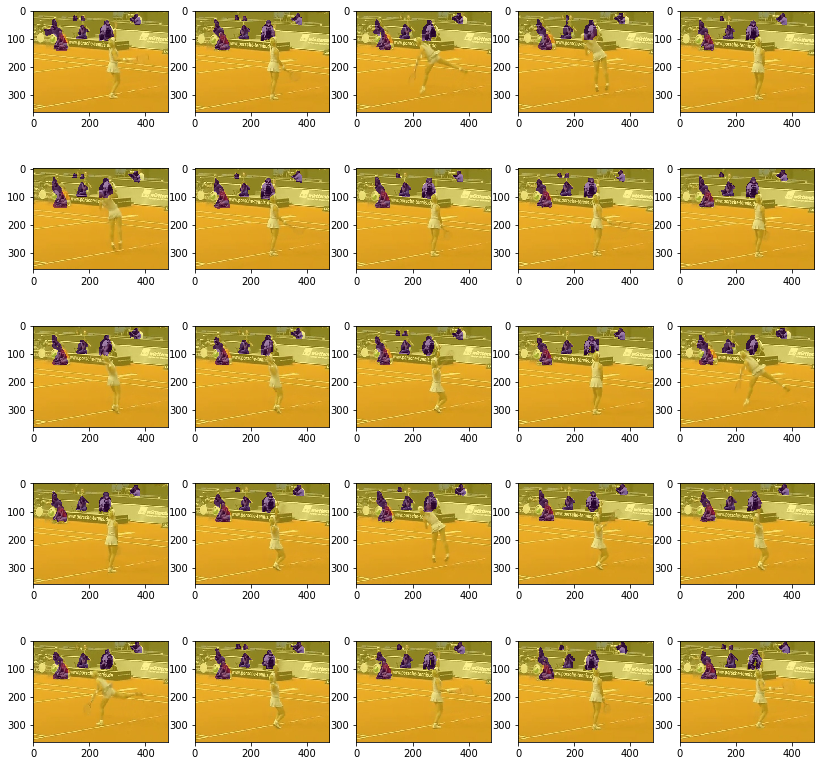

In [26]:
imgs = os.listdir('%s/%s' % (fpath, folder))

masks = np.load('%s/%s' % (maskpath, '2326.npy'))

assert len(imgs) == len(masks)

plt.figure(figsize=(14, 14))
for ii in range(min(len(masks), 25)):
    impath = '%s/%s/%s' % (fpath, folder, imgs[ii])
    plt.subplot(5, 5, ii+1)
    plt.imshow(cv2.cvtColor(imread(impath), cv2.COLOR_BGR2RGB))
    plt.imshow(masks[ii], alpha=0.5)
plt.show()